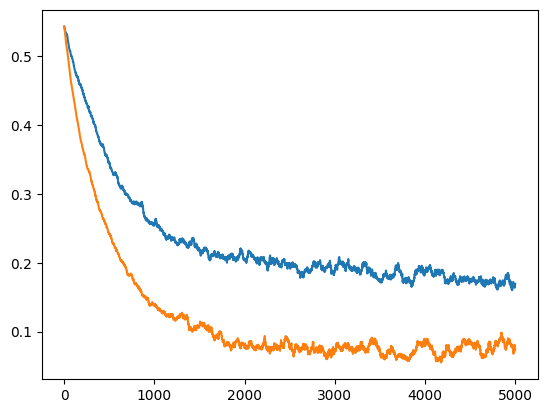

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import math

def random_walk_true_value(num_states, trans_len):
    trans_prob = 0.5 / trans_len
    order = num_states
    i = np.identity(order)
    t = np.zeros_like(i)
    for row in range(order):
        for col in range(order):
            dis = row - col
            if dis >= -trans_len and dis <= trans_len and dis != 0:
                t[row][col] = trans_prob

    b = np.zeros(order)
    for row in range(order):
        for n in range(trans_len):
            if row - n - 1 < 0:
                b[row] -= trans_prob
            if row + n + 1 >= order:
                b[row] += trans_prob
    m = i - t
    s = np.linalg.solve(m,b)
    return s


class RandomWalk:
    def __init__(self, num_states, trans_len):
        self.num_states = num_states
        self.trans_len = trans_len
        self.state = self.num_states // 2
       
    def reset(self):
        self.state = self.num_states // 2
        return self.state

    def step(self):
        offset = np.random.randint(-self.trans_len, self.trans_len)
        if offset >=0:
            offset += 1
        self.state += offset
        if self.state < 0:
            return -1, self.num_states
        elif self.state < self.num_states:
            return 0, self.state
        else:
            return 1, self.num_states
        
    def is_terminated(self, state):
        return state >= self.num_states
    
class PolynomialApproximator:
    def __init__(self, env, order):
        self.num_states = env.num_states
        self.order = order
        self.w = np.zeros(self.order + 1)

    def reset(self):
        self.w = np.zeros(self.order + 1)

    def to_features(self, state):
        return np.power(state/float(self.num_states), np.arange(self.order + 1))

    def predicate(self, state):
        return np.dot(self.to_features(state), self.w)
    
    def train(self, state, target, alpha):
        features = self.to_features(state)
        v_hat = np.dot(features, self.w)
        self.w += alpha * (target - v_hat) * features

class FourierApproximator:
    def __init__(self, env, order):
        self.num_states = env.num_states
        self.order = order
        self.w = np.zeros(self.order + 1)

    def reset(self):
        self.w = np.zeros(self.order + 1)

    def to_features(self, state):
        return np.cos(state/float(self.num_states)*np.pi*np.arange(self.order + 1))

    def predicate(self, state):
        return np.dot(self.to_features(state), self.w)
    
    def train(self, state, target, alpha):
        features = self.to_features(state)
        v_hat = np.dot(features, self.w)
        self.w += alpha * (target - v_hat) * features


def gradient_monte_carlo(env, approximator, num_episodes, alpha, gamma = 1.0, callback = None):
    for episode in range(num_episodes):
        state = env.reset()
        rewards = []
        states = [state]
        while True:
            reward, next_state = env.step()
            rewards.append(reward)
            if next_state >= env.num_states:
                break
            states.append(next_state)
            state = next_state
        g = 0
        for t in range(len(rewards)-1,-1,-1):
            g = g*gamma + rewards[t]
            approximator.train(states[t], g, alpha)
        if callback:
            callback(episode)

class RMSE:
    def __init__(self, true_value, approximator, num_episodes) -> None:
        self.true_value = true_value
        self.approximator = approximator
        self.rmse = np.zeros(num_episodes)

    def __call__(self, episode):
        #v_hats = np.zeros(self.approximator.num_states)
        s = np.arange(self.approximator.num_states).reshape(-1,1)
        v_hats = self.approximator.predicate(s)
        #for s in range(self.approximator.num_states):
        #    v_hats[s] = self.approximator.predicate(s)
        self.rmse[episode] = np.sqrt(np.power((v_hats - self.true_value),2.0).mean())


num_states = 1000
trans_len = 100
num_episodes = 5000
num_avg = 30
true_value = random_walk_true_value(num_states, trans_len)
env = RandomWalk(num_states, trans_len)

params=[
    [np.zeros(num_episodes), PolynomialApproximator, 5, 0.0001],
    [np.zeros(num_episodes), FourierApproximator, 5, 0.00005],
]

for param in params:
    avg_rmse = param[0]
    Approximator = param[1]
    order = param[2]
    alpha = param[3]
    for n in range(num_avg):
        approximator = Approximator(env, order)
        rmse = RMSE(true_value, approximator, num_episodes)
        gradient_monte_carlo(env, approximator, num_episodes, alpha, callback=rmse)
        avg_rmse += rmse.rmse
    avg_rmse /= num_avg


for param in params:
    avg_rmse = param[0]
    plt.plot(range(len(avg_rmse)), avg_rmse)

